In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.insert(0, '../src')

In [3]:
! pip install -i https://test.pypi.org/simple/ my-krml_14229898==0.2.7

Looking in indexes: https://test.pypi.org/simple/

[notice] A new release of pip is available: 23.2.1 -> 23.3
[notice] To update, run: pip install --upgrade pip


# Applying CRIPS-DM Methodology to a Business Problem

## Dataset 2 - Predicting Customer Churn in the Telecomunication Provider

### 3. Modeling

#### 3.2 XGBoost Model

**[3.1]** Import the pandas and numpy packages

In [4]:
import pandas as pd
import numpy as np

**[3.2]** Import the `load_sets` from my custom package

#### 1. Load the datset

In [5]:
from my_krml_14229898.data.sets import load_sets_smote, load_sets

**[3.3]** Load the SMOTE saved sets from `data/processed`

In [6]:
X_train_resampled, y_train_resampled = load_sets_smote(path='../data/processed/')

**[3.4]** Load the `validating` and `testing` sets from `data/processed`

In [7]:
X_train, y_train, X_val, y_val, X_test, y_test = load_sets('../data/processed/')

#### 3.2.1 Train XGBoost Model `(With SMOTE df)`

**[3.5]** Import the XGBClassifier package

In [8]:
from xgboost import XGBClassifier

**[3.6]** Instantiate a `XGBClassifier` class

In [9]:
xgb_smote = XGBClassifier()

**[3.7]** Import `fit_asses_classifier` function from the customer package

In [10]:
from my_krml_14229898.models.performance import fit_assess_classifier

**[3.8]** Set the performance metrics to be used for the model.

In [11]:
metrics = ['precision', 'recall', 'f1', 'roc_auc']

**[3.9]** Fit the model and display the performance on training and validation sets.

In [12]:
xgb_smote = fit_assess_classifier(xgb_smote, X_train_resampled, y_train_resampled, X_val, y_val, metrics=metrics)

                f1  precision    recall   roc_auc
Training  0.970106   0.964525  0.975752  0.969932
                  f1  precision    recall   roc_auc
Validation  0.588083   0.595801  0.580563  0.714494


**[4.0]** Import `plot_confusion_matrix`, `plot_roc_auc_curve`, and `permutation_importance` from the custom package

In [13]:
from my_krml_14229898.models.performance import plot_confusion_matrix, plot_roc_auc_curve, permutation_importance

**[4.1]** Plot the Confusion Matrix of Traning and Validation set

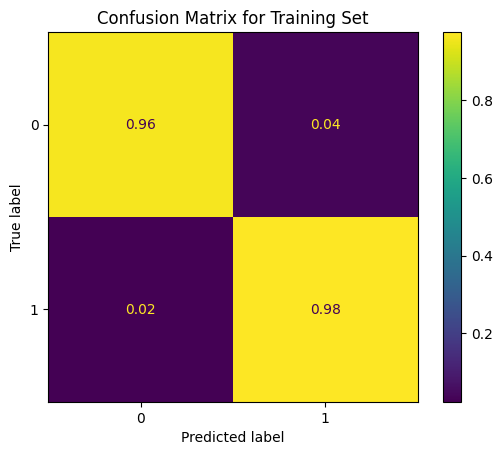

In [14]:
plot_confusion_matrix(xgb_smote, X_train_resampled, y_train_resampled, "Training")

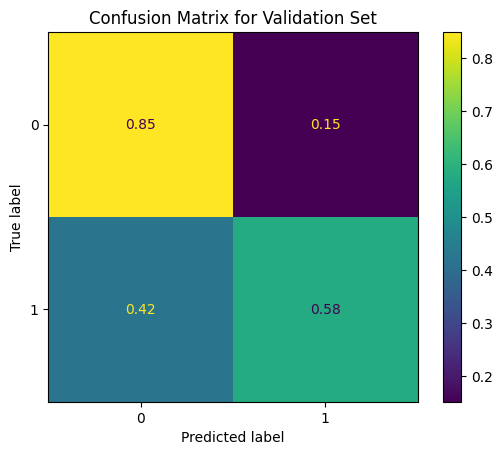

In [15]:
plot_confusion_matrix(xgb_smote, X_val, y_val, "Validation")

**[4.2]** Plot the ROC-AUC Curve of Training and Validation set

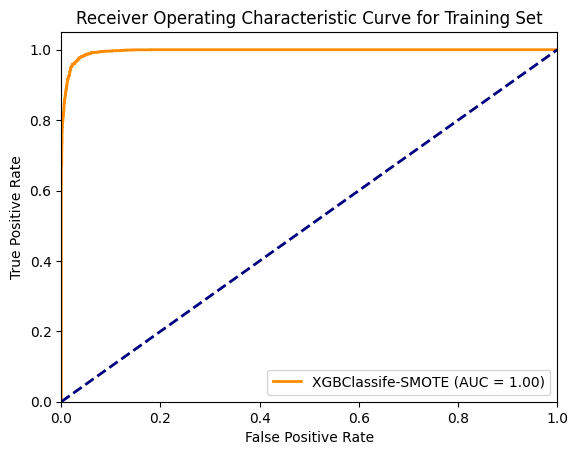

In [16]:
plot_roc_auc_curve(xgb_smote, X_train_resampled, y_train_resampled, "Training", 'XGBClassife-SMOTE')

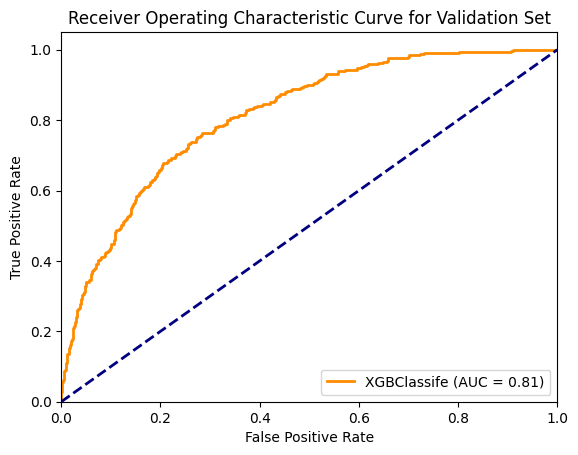

In [17]:
plot_roc_auc_curve(xgb_smote, X_val, y_val, "Validation", "XGBClassife")

**[4.3]** Display the Permutations Importance

In [18]:
df = pd.read_csv("../data/processed/df_cleaned.csv")
target = "Churn"

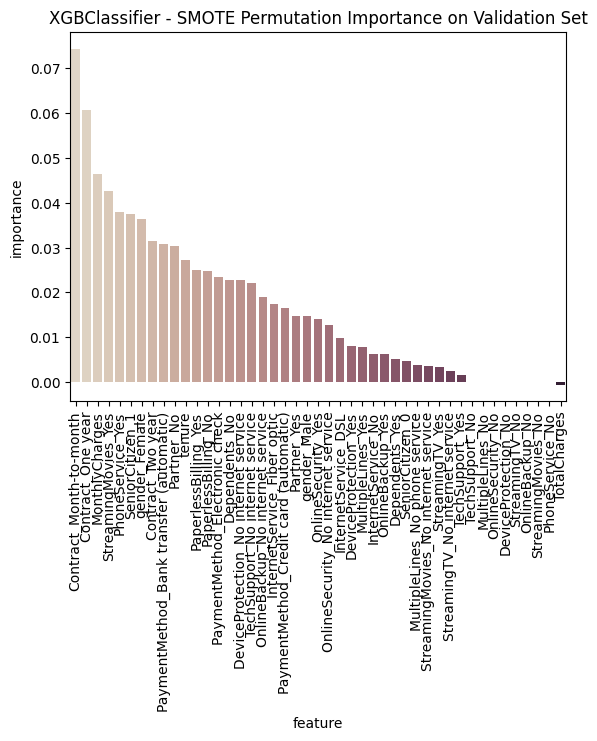

In [20]:
xgb_smote_permu = permutation_importance(df, target, xgb_smote, X_val, y_val, "Validation", "XGBClassifier - SMOTE")

In [21]:
xgb_smote_permu

,feature,importance
0,Contract_Month-to-month,0.074366
1,Contract_One year,0.060602
2,MonthlyCharges,0.046316
3,StreamingMovies_Yes,0.042597
4,PhoneService_Yes,0.037977
5,SeniorCitizen_1,0.037408
6,gender_Female,0.036318
7,Contract_Two year,0.031414
8,PaymentMethod_Bank transfer (automatic),0.030869
9,Partner_No,0.030301


**[4.4]** Import `dump` from `joblib` and save the fitted model into the folder `models` as a file called `xgbclassifier-smote.joblib`

In [22]:
from joblib import dump

dump(xgb_smote, '../models/xgboostclassifier-smote.joblib')

['../models/xgboostclassifier-smote.joblib']

#### 3. Hyperparameter tuning with Hyperopt

**[4.5]** Import Trials, STATUS_OK, tpe, hp, fmin from hyperopt package

In [23]:
from hyperopt import Trials, STATUS_OK, tpe, hp, fmin
rstate = np.random.default_rng(42)

**[4.6]** Define the search space for XGBClassifier hyperparameters


In [24]:
space = {
    'n_estimators': hp.quniform('n_estimators', 100, 1000, 1),
    'max_depth': hp.quniform('max_depth', 1, 13, 1),
    'learning_rate': hp.loguniform('learning_rate', -5, 0),
    'gamma': hp.uniform('gamma', 0, 1),
    'min_child_weight': hp.quniform('min_child_weight', 1, 10, 1),
    'subsample': hp.uniform('subsample', 0.5, 1),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1)
}

C = 0.00001 - 100
penalty = l2 or None
max_iter = 100 - 5000
solver = 'lbfgs', 'newton-cg', 'newton-cholesky', 'sag', 'saga'
fit_intercept = True, False

**[4.7]** Define a function called `objective` with the following logics:
- input parameters: hyperparameter seacrh space (`space`)
- logics: train a logistic model with the search space and calculate the average `recall` score for cross validation with 5 folds
- output parameters: dictionary with the loss score and STATUS_OK

In [25]:
def objective(space):
    from sklearn.model_selection import cross_val_score
    
    classifier = XGBClassifier(
        n_estimators = int(space['n_estimators']),
        max_depth = int(space['max_depth']),
        learning_rate = space['learning_rate'],
        gamma = space['gamma'],
        min_child_weight = space['min_child_weight'],
        subsample = space['subsample'],
        colsample_bytree = space['colsample_bytree']
    )

    acc = cross_val_score(classifier, X_train_resampled, y_train_resampled, cv=5, scoring='recall').mean()
    
    return {'loss': -acc,'status': STATUS_OK}

**[4.8]** Launch Hyperopt search and save the result in a variable called `best`

In [26]:
best = fmin(
    fn=objective,
    space=space,
    algo=tpe.suggest,
    max_evals=100,
    rstate=rstate,
)

100%|██████████| 100/100 [12:22<00:00,  7.42s/trial, best loss: -0.8713092941428652]


**[4.9]** Print the best set of hyperparameters

In [27]:
print("Best parameters: ", best)

Best parameters:  {'colsample_bytree': 0.68586805429438, 'gamma': 0.6953937444059428, 'learning_rate': 0.007028121669678653, 'max_depth': 7.0, 'min_child_weight': 1.0, 'n_estimators': 364.0, 'subsample': 0.9826318978493157}


In [28]:
best_params = {
    'colsample_bytree': best['colsample_bytree'],
    'gamma': best['gamma'],
    'learning_rate': best['learning_rate'],
    'max_depth': int(best['max_depth']),
    'min_child_weight': int(best['min_child_weight']),
    'n_estimators': int(best['n_estimators']),
    'subsample': best['subsample']
}

**[5.0]** Instantiate a XGBClassifier with the best set of hyperparameters

In [29]:
xgb_smote_2 = XGBClassifier(**best_params)

**[5.1]** Fit the model and display the performance on training and validation sets.


In [30]:
xgb_smote_2 = fit_assess_classifier(xgb_smote_2, X_train_resampled, y_train_resampled, X_val, y_val, metrics)

                f1  precision    recall   roc_auc
Training  0.890267   0.855016  0.928548  0.885548
                  f1  precision   recall   roc_auc
Validation  0.636782   0.578288  0.70844  0.754811


**[5.2]** Display the confusion matrix of the Validation set.


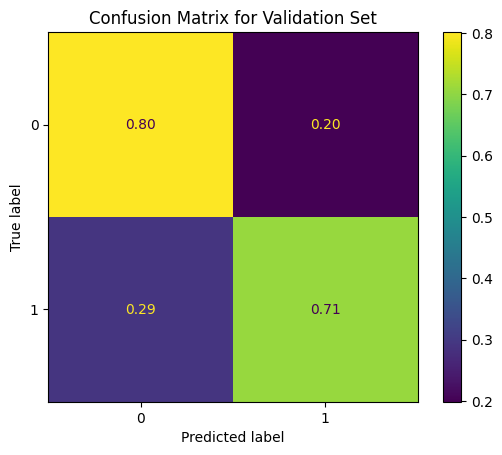

In [31]:
plot_confusion_matrix(xgb_smote_2, X_val, y_val, "Validation")

**[5.3]** Plot the ROC-AUC Curve of Validation Set

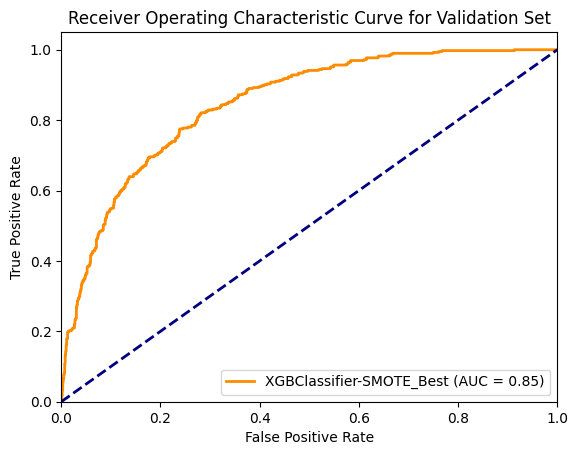

In [32]:
plot_roc_auc_curve(xgb_smote_2, X_val, y_val, "Validation", "XGBClassifier-SMOTE_Best")

**[5.4]** Display the Permutations Importance

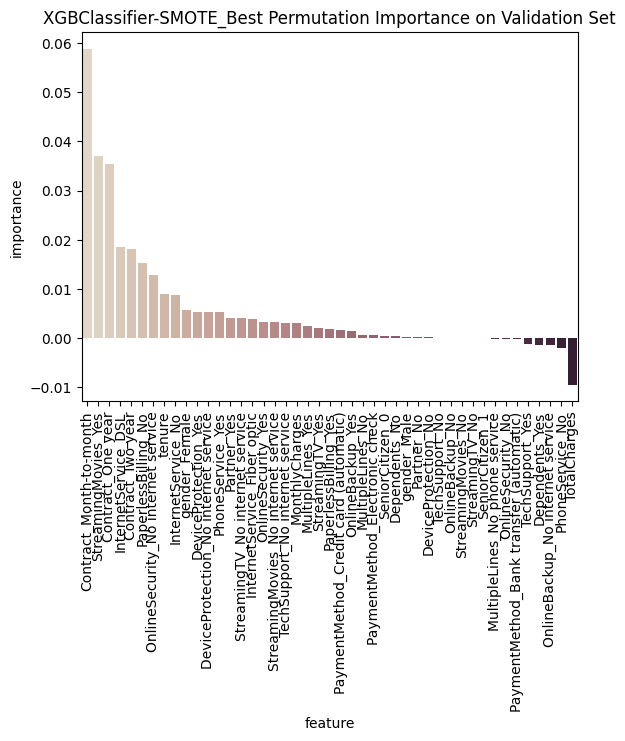

In [33]:
xgb_smote_best_permu = permutation_importance(df, target, xgb_smote_2, X_val, y_val, "Validation", "XGBClassifier-SMOTE_Best")

In [34]:
xgb_smote_2 = fit_assess_classifier(xgb_smote_2, X_train_resampled, y_train_resampled, X_val, y_val, metrics=metrics)

                f1  precision    recall   roc_auc
Training  0.890267   0.855016  0.928548  0.885548
                  f1  precision   recall   roc_auc
Validation  0.636782   0.578288  0.70844  0.754811


#### 3.2.2 Train XGBoost Model `(With NO SMOTE df)`

In [40]:
xgb = XGBClassifier()

In [41]:
xgb = fit_assess_classifier(xgb, X_train, y_train, X_val, y_val, metrics=metrics)

                f1  precision    recall   roc_auc
Training  0.927602     0.9447  0.911111  0.945856
                 f1  precision    recall  roc_auc
Validation  0.57784   0.639752  0.526854  0.70634


**[4.1]** Plot the Confusion Matrix of Traning and Validation set

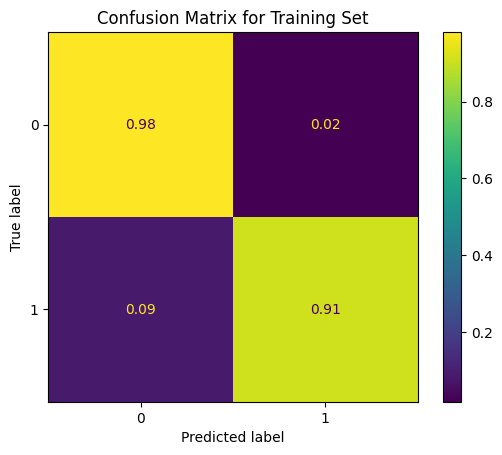

In [42]:
plot_confusion_matrix(xgb, X_train, y_train, "Training")

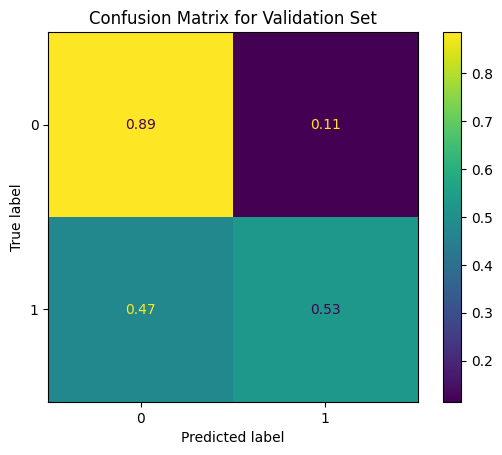

In [43]:
plot_confusion_matrix(xgb, X_val, y_val, "Validation")

**[4.2]** Plot the ROC-AUC Curve of Training and Validation set

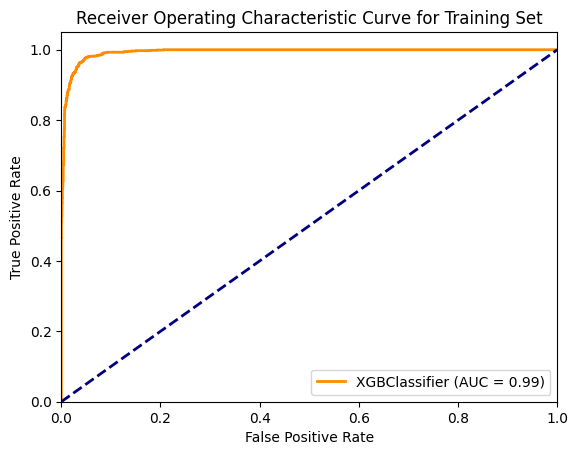

In [44]:
plot_roc_auc_curve(xgb, X_train, y_train, "Training", 'XGBClassifier')

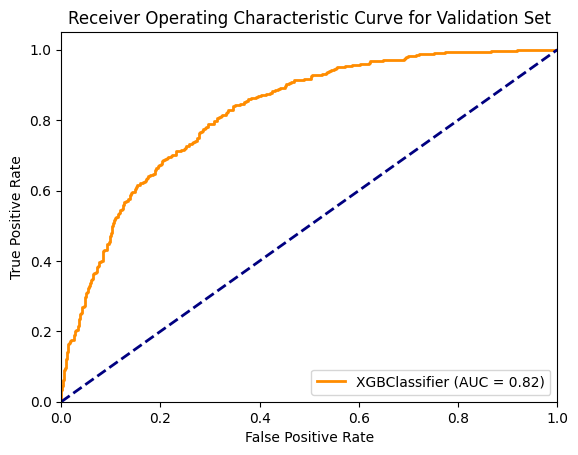

In [45]:
plot_roc_auc_curve(xgb, X_val, y_val, "Validation", "XGBClassifier")

**[4.3]** Display the Permutations Importance

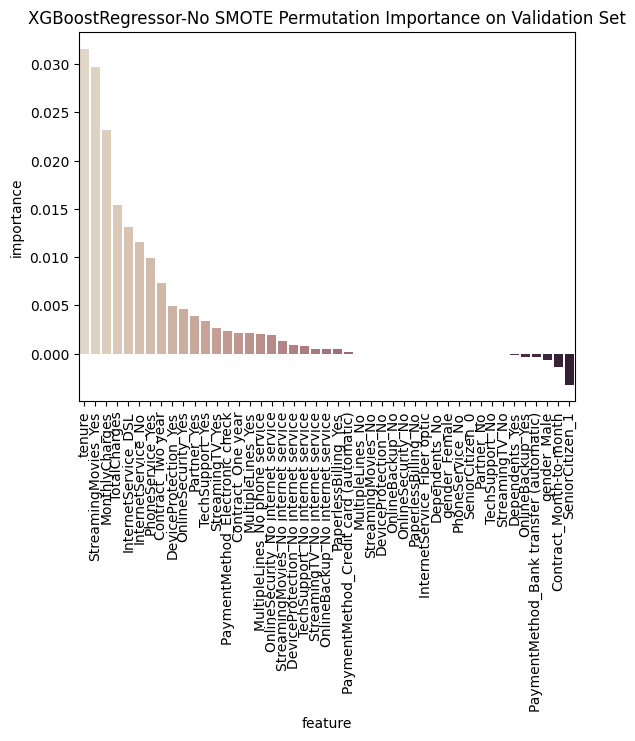

In [46]:
xgb_permu = permutation_importance(df, target, xgb, X_val, y_val, "Validation", "XGBoostRegressor-No SMOTE")

In [47]:
xgb_permu

,feature,importance
0,tenure,0.031604
1,StreamingMovies_Yes,0.029756
2,MonthlyCharges,0.023194
3,TotalCharges,0.015447
4,InternetService_DSL,0.013101
5,InternetService_No,0.011561
6,PhoneService_Yes,0.009879
7,Contract_Two year,0.007321
8,DeviceProtection_Yes,0.004951
9,OnlineSecurity_Yes,0.004643


#### 3. Hyperparameter tuning with Hyperopt

**[4.5]** Import Trials, STATUS_OK, tpe, hp, fmin from hyperopt package

In [48]:
from hyperopt import Trials, STATUS_OK, tpe, hp, fmin
rstate = np.random.default_rng(42)

**[4.6]** Define the search space for logistic regression hyperparameters


In [49]:
space = {
    'n_estimators': hp.quniform('n_estimators', 100, 1000, 1),
    'max_depth': hp.quniform('max_depth', 1, 13, 1),
    'learning_rate': hp.loguniform('learning_rate', -5, 0),
    'gamma': hp.uniform('gamma', 0, 1),
    'min_child_weight': hp.quniform('min_child_weight', 1, 10, 1),
    'subsample': hp.uniform('subsample', 0.5, 1),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1)
}

C = 0.00001 - 100
penalty = l2 or None
max_iter = 100 - 5000
solver = 'lbfgs', 'newton-cg', 'newton-cholesky', 'sag', 'saga'
fit_intercept = True, False

**[4.7]** Define a function called `objective` with the following logics:
- input parameters: hyperparameter seacrh space (`space`)
- logics: train a logistic model with the search space and calculate the average `recall` score for cross validation with 5 folds
- output parameters: dictionary with the loss score and STATUS_OK

In [51]:
def objective(space):
    from sklearn.model_selection import cross_val_score
    
    classifier = XGBClassifier(
        n_estimators = int(space['n_estimators']),
        max_depth = int(space['max_depth']),
        learning_rate = space['learning_rate'],
        gamma = space['gamma'],
        min_child_weight = space['min_child_weight'],
        subsample = space['subsample'],
        colsample_bytree = space['colsample_bytree']
    )

    acc = cross_val_score(classifier, X_train, y_train, cv=5, scoring='recall').mean()
    
    return {'loss': -acc,'status': STATUS_OK}

**[4.8]** Launch Hyperopt search and save the result in a variable called `best`

In [52]:
best = fmin(
    fn=objective,
    space=space,
    algo=tpe.suggest,
    max_evals=100,
    rstate=rstate,
)

  0%|          | 0/100 [00:00<?, ?trial/s, best loss=?]

100%|██████████| 100/100 [11:50<00:00,  7.10s/trial, best loss: -0.5475555555555556]


**[4.9]** Print the best set of hyperparameters

In [53]:
print("Best parameters: ", best)

Best parameters:  {'colsample_bytree': 0.9912584985947989, 'gamma': 0.6247504292722001, 'learning_rate': 0.11602027725337177, 'max_depth': 4.0, 'min_child_weight': 10.0, 'n_estimators': 731.0, 'subsample': 0.7130553884307035}


In [54]:
best_params = {
    'colsample_bytree': best['colsample_bytree'],
    'gamma': best['gamma'],
    'learning_rate': best['learning_rate'],
    'max_depth': int(best['max_depth']),
    'min_child_weight': int(best['min_child_weight']),
    'n_estimators': int(best['n_estimators']),
    'subsample': best['subsample']
}

**[5.0]** Instantiate a XGBClassifier with best set of hyperparameters

In [55]:
xgb_2 = XGBClassifier(**best_params)

**[5.1]** Fit the model and display the performance on training and validation sets.


In [57]:
xgb_2 = fit_assess_classifier(xgb_2, X_train, y_train, X_val, y_val, metrics)

                f1  precision    recall   roc_auc
Training  0.833097   0.889899  0.783111  0.873935
                  f1  precision    recall   roc_auc
Validation  0.559889   0.614679  0.514066  0.695025


**[5.2]** Display the confusion matrix of the Validation set.


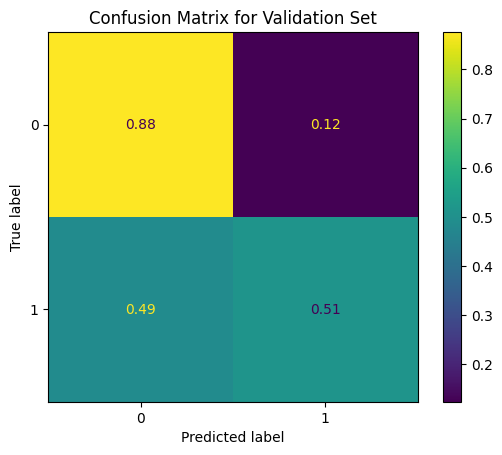

In [58]:
plot_confusion_matrix(xgb_2, X_val, y_val, "Validation")

**[5.3]** Plot the ROC-AUC Curve of Validation Set

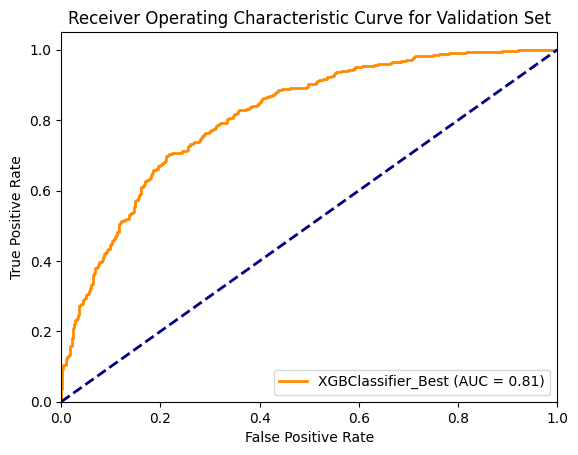

In [59]:
plot_roc_auc_curve(xgb_2, X_val, y_val, "Validation", "XGBClassifier_Best")

**[5.4]** Display the Permutations Importance

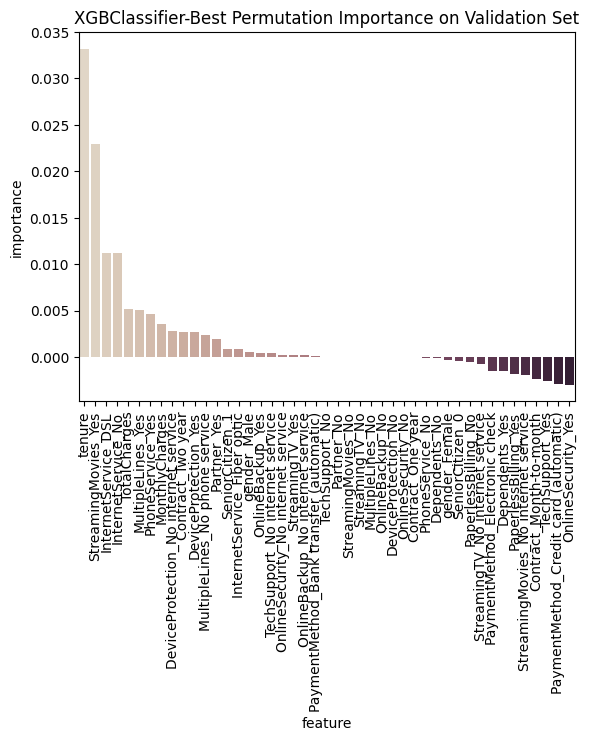

In [60]:
log_best_permu = permutation_importance(df, target, xgb_2, X_val, y_val, "Validation", "XGBClassifier-Best")